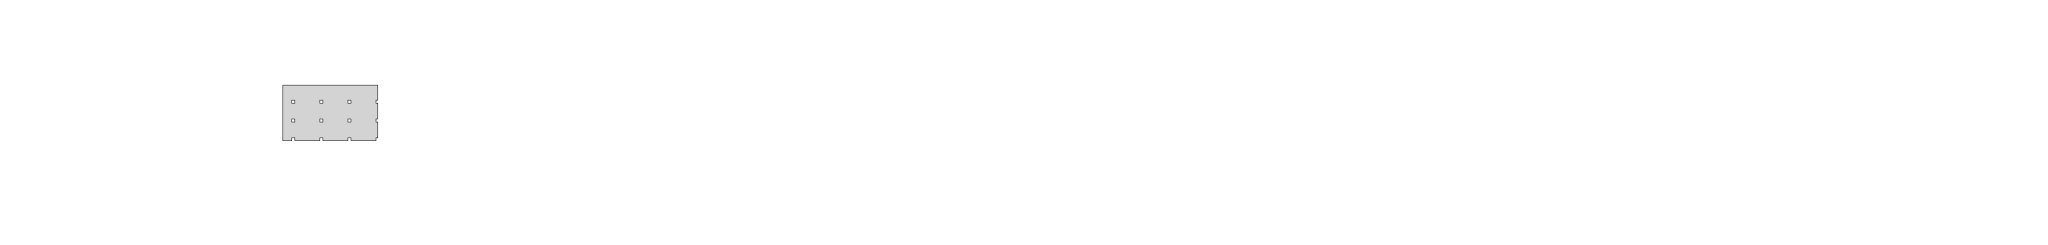

In [1]:
"""
Extinguisher.ipynb
TODO:
- [x] Get floor definition from Revit
- [x] Add Obstacles
- [ ] Add Doors (extinguisher to be closest to access points)
"""
__author__ = "Bob YX Lee"
import sys 
import os
import json
import drawsvg as dw
import random
from pprint import pprint
from copy import deepcopy
import numpy as np

sys.path.append("./packages")

from geom.Line2D import Line2D

MM = 100

data = {}
# Get random data point
datafiles = os.listdir("./dataset")
data_path = os.path.join("./dataset", "test_api.json")#random.choice(datafiles))
data = {}
with open(data_path, "r") as f:
    data = json.loads(f.read())

d = dw.Drawing(4000, 480, origin = (-MM*4, -MM*2), id_prefix='pic')
dpath = dw.Path(stroke = 'black', fill = 'lightgray')
#print(data)
verts = data["room_dict"]["vertices"]
obs = data["room_dict"]["obstacles"]
for i, p in enumerate(verts):
    if i == 0: dpath.M(p[0]/MM, -p[1]/MM); continue
    dpath.L(p[0]/MM, -p[1]/MM);

for o in obs:
    for i, p in enumerate(o):
        if i == 0: dpath.M(p[0]/MM, -p[1]/MM); continue
        dpath.L(p[0]/MM, -p[1]/MM);
    
d.append(dpath)
d

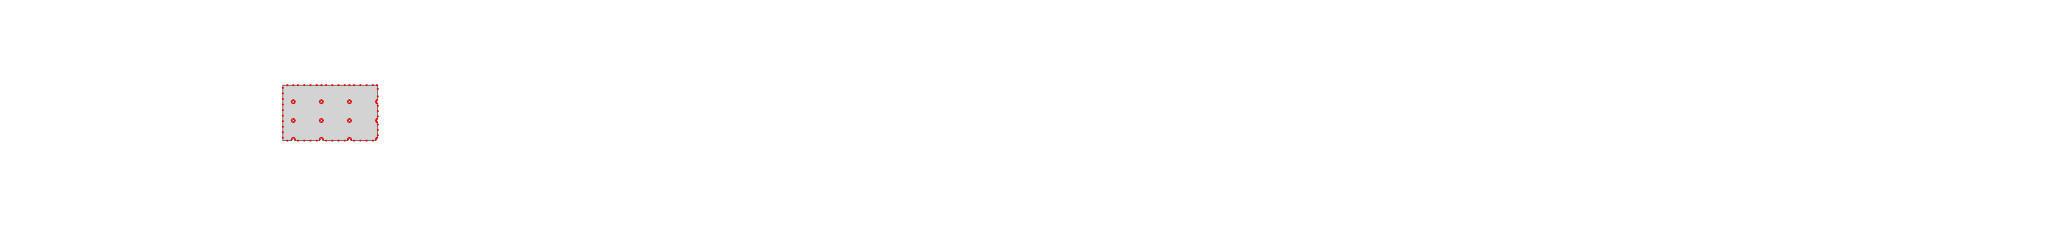

In [2]:
"""
Prepare candidate slots where extinguishers could be placed
"""
from geom.Room import Room

def drawPt(d, pt, color = "red"):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 2, fill=color))
    pass

rm = Room()
rm.vertices = deepcopy(verts)
rm.obstacles = deepcopy(obs)
ext_slots = rm.gExtSlots(1000)
d2 = deepcopy(d)
for e in ext_slots: drawPt(d2, e)
d2


In [3]:
"""
Rule based solving algorithm
1. Pick a random ext slot to place on
2. Check whether coverage passes
3. If not pass, place at wall closest to the centroid of the diff
    3.1. Go to 2
4. If pass, check travel
5. If not pass, place extinguisher at most remote point

Rank by no. extinguishers, and return all options with the minimal no. extinguishers
"""

exslt = deepcopy(ext_slots)

def drawPath(dwg, path, fill="yellow", fill_opacity = 0.3):
    dpath = dw.Path(fill = fill, fill_opacity = fill_opacity)
    for i, v in enumerate(path):
        if i == 0: dpath.M(v[0]/MM, -v[1]/MM); continue;
        dpath.L(v[0]/MM, -v[1]/MM)
    dwg.append(dpath)

def drawCoverDiff(dwg, coverage, diff):
    """
    Draws coverage and difference
    """
    for c in coverage: drawPath(dwg, c)
    for d in diff: drawPath(dwg, d, "red")

# Pick a diff and find the centroid
def centroid(points):
    pc = np.array(points)
    return np.mean(points, axis = 0).tolist()

FAIL


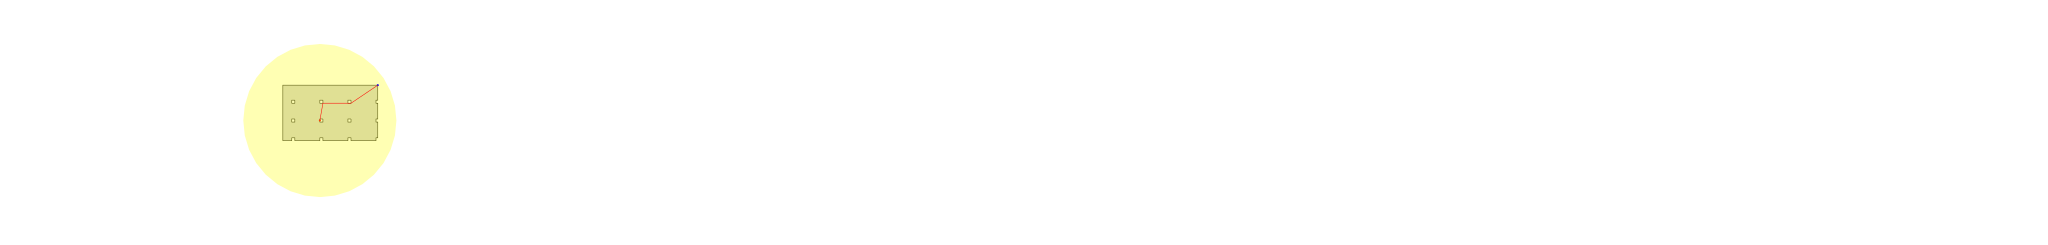

In [4]:
from geom.PointCloud import closestPt
d3 = deepcopy(d)

def drawCoverResults(d, exts, res):
    for e in exts: drawPt(d, e)
    drawCoverDiff(d, res["coverage"], res["diff"])
    pass

def drawPathPlines(d, res, SCALE = MM):
    for p in res["paths"]:
        cstroke = "blue"
        if p["distance"] > 15000: cstroke = "red"
        tpath = dw.Path(stroke = cstroke, fill = 'none')
        for i, v in enumerate(p["path"]):
            if(i == 0):
                tpath.M(v[0]/SCALE, -v[1]/SCALE); continue
            tpath.L(v[0]/SCALE, -v[1]/SCALE)
            if(i == len(p["path"]) -1):
                drawPt(d, [v[0], v[1]], 'blue');
        pass
        d.append(tpath)
    pass

def solvePlacement(rm, exslt, navmesh, picked_exts = []):
    count = 0 # DEBUG
    #max_count = 2 # DEBUG
    cover_pass = False
    cdiffs = []
    while cover_pass == False:
        #if count == max_count : break # DEBUG
        # If we already have exts, check them first
        if(count == 0 and len(picked_exts) > 0):
            res = rm.extCoverChk(picked_exts)
            cdiffs.extend(res["diff"])
            cover_pass = res["result"]
            drawCoverResults(d3, picked_exts, res)
            count += 1
            continue
        # Otherwise, if its 1st loop, pick a random
        # extslot to place an extinguisher
        if(count == 0):
            pidx = random.randint(0, len(exslt) -1)
            cext = exslt.pop(pidx)
        else:
            # If not first loop, there's already a coverage shortfall. 
            # Pick a random shortfall zone and get its centroid
            c = centroid(random.choice(cdiffs))
            # Then find the extslot closest to the centroid.
            cext = closestPt(c, exslt)
        picked_exts.append(cext)
        res = rm.extCoverChk(picked_exts)
        drawPt(d3,cext)
        drawCoverDiff(d3, res["coverage"], res["diff"])
        cdiffs.extend(res["diff"])
        cover_pass = res["result"]
        count += 1 # DEBUG
    # Now coverage is settled, we have to check the travel distance
    # From most remote. If distance > 15000, just put it at the
    # extslt closest to the remote point!
    tres = rm.extTravelChk(navmesh, picked_exts)
    drawPathPlines(d3, tres)
    print(tres["result"])
    if(tres["result"] == "PASS"):
        return picked_exts
    picked_exts.append(tres["remote"])
    return picked_exts
navmesh = data["navmesh"]
#print(navmesh)
pre_exts = [random.choice(exslt).tolist()]
exts = solvePlacement(rm, exslt, navmesh, pre_exts)
d3

In [5]:
# Test builtin function
rm.extSolve(navmesh, exslt)

PASS


[[22645.967741935463, -7277.741935483909],
 [33220.9677419355, 3317.2580645160424]]

In [14]:
# Test FastAPI endpoint
import requests
FIRE_OPT = "http://localhost:41983/ext_solve_all"
payload = {
           "room_dict": data["room_dict"], 
           "navmesh": navmesh, 
           "exts": [random.choice(exslt).tolist()],
           "resolution": {"units": 1000}
          }
res = requests.post(FIRE_OPT, json = payload)
print(res)
outcome = res.json()
print(outcome)

<Response [200]>
None
